### input train data

In [37]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import mlflow
import mlflow.sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [38]:
# train input
df = pd.read_csv(r"./train/train.csv")
column_name_list = df.columns.tolist()
train_df = df

# opsdata input
ops_df = pd.read_csv(r".\test\opsdata.csv")
ops_df["label"].replace(0,-1,inplace=True)
opsdata_df = ops_df.iloc[:,2:-1]

### PreProcess

In [39]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_df)

# Standardize the new data using the same scaler object used for training data
X_new_scaled = scaler.transform(opsdata_df)

## MLflow used

In [40]:
mlflow.start_run(experiment_id=None, run_name=None, tags=None)

<ActiveRun: >

In [56]:
try:
    # Log the scaler
    # mlflow.sklearn.log_model(scaler, "scaler")

    # Create the Isolation Forest model
    contamination = 'auto'
    isolation_forest = IsolationForest(contamination=contamination, random_state=42)
    
    # Train the model
    isolation_forest.fit(X_scaled)
    
    # Log the model
    mlflow.sklearn.log_model(isolation_forest, "isolation_forest")
    
    # Log parameters (in this case, contamination)
    mlflow.log_param("contamination", contamination)
    
    # Optionally, log any other metrics, parameters, or artifacts

    # Make predictions using the trained Isolation Forest model
    labels = isolation_forest.predict(X_new_scaled)
    scores = isolation_forest.decision_function(X_new_scaled)

    # Add the prediction labels and scores to the new data DataFrame
    ops_df['Prediction_Label'] = labels
    ops_df['Anomaly_Score'] = scores

    # 既存のコードに続けて以下を追加
    y_true = ops_df['label']
    y_pred = ops_df['Prediction_Label']

    # Calculate Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=-1)  # pos_labelは外れ値のラベルを指定
    recall = recall_score(y_true, y_pred, pos_label=-1)  # pos_labelは外れ値のラベルを指定

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)

finally:
    # End the MLflow run
    mlflow.end_run()

c:\Users\kohei\AppData\Local\Programs\Python\Python310\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\kohei\AppData\Local\Programs\Python\Python310\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### Calulate Metrics

In [57]:
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Accuracy: 0.24175824175824176
Precision: 0.9444444444444444
Recall: 0.11038961038961038


In [58]:
# 予測が間違っていた行だけを抜き出す
incorrect_predictions_df = ops_df[ops_df['label'] != ops_df['Prediction_Label']]

# 抜き出したDataFrameを表示（または保存等）
print(incorrect_predictions_df.iloc[:,0])

0                   紅蓮華
1                  残響散歌
2                  絆ノ奇跡
3               ミックスナッツ
4              SOUVENIR
             ...       
176    ダイアローグ+インビテーション!
177               FLARE
178            Daylight
179            Blow out
181        LIES GOES ON
Name: music name, Length: 138, dtype: object


### Visualize Tree

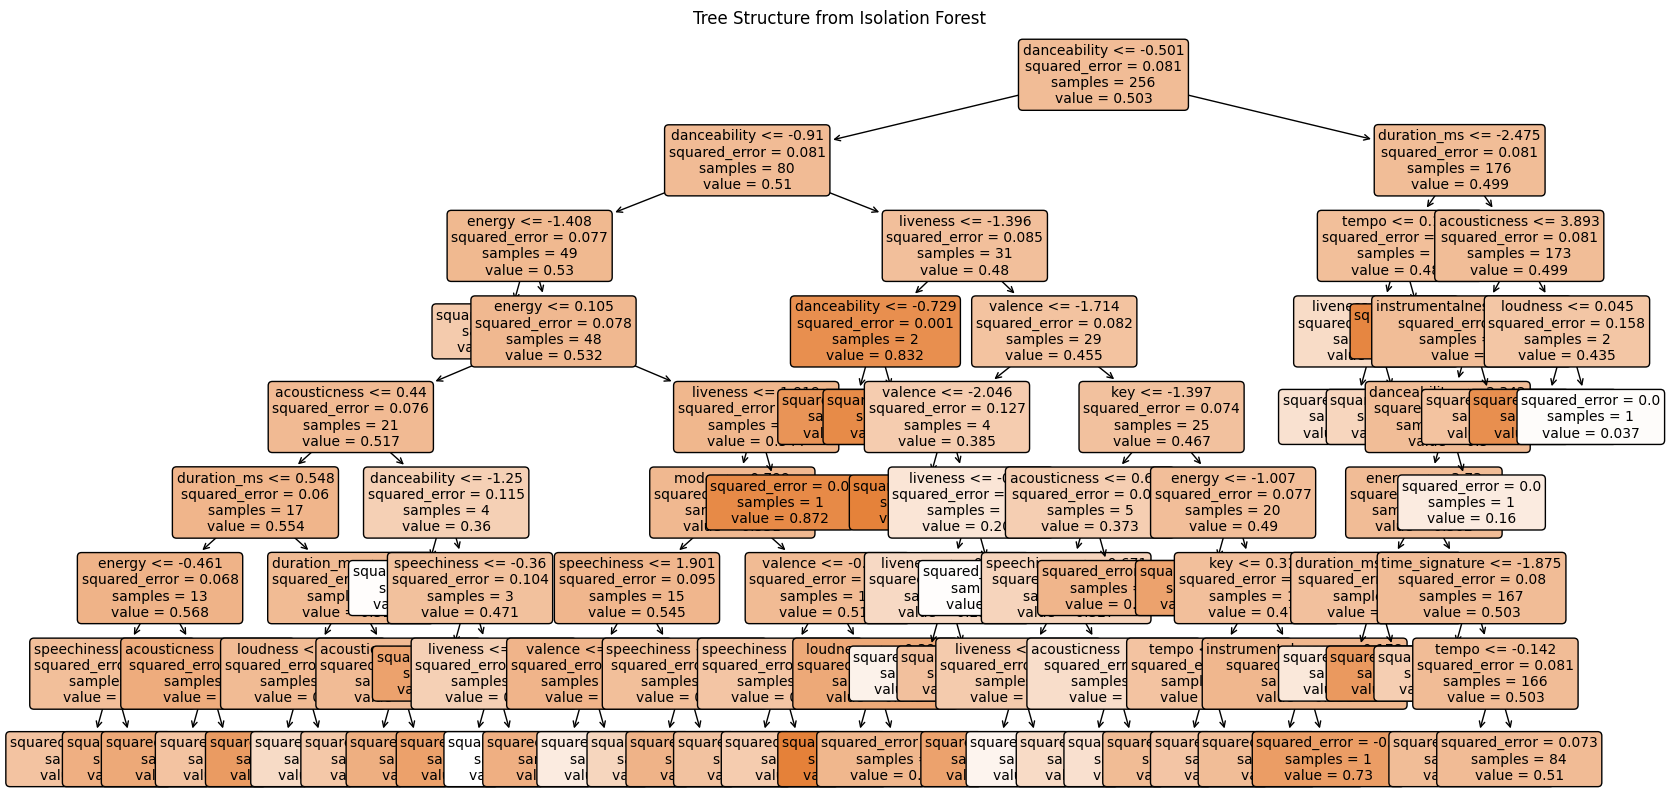

In [19]:
# Select one tree from the ensemble of trees in the Isolation Forest model
single_tree = isolation_forest.estimators_[0]

# Plot the tree structure
plt.figure(figsize=(20, 10))
plot_tree(single_tree, filled=True, feature_names=df.columns.to_list(), rounded=True, fontsize=10)
plt.title("Tree Structure from Isolation Forest")
plt.show()

In [34]:
# Show the first few rows of the new data with prediction labels and anomaly scores
ops_df.to_csv('./result/ops_result.csv')

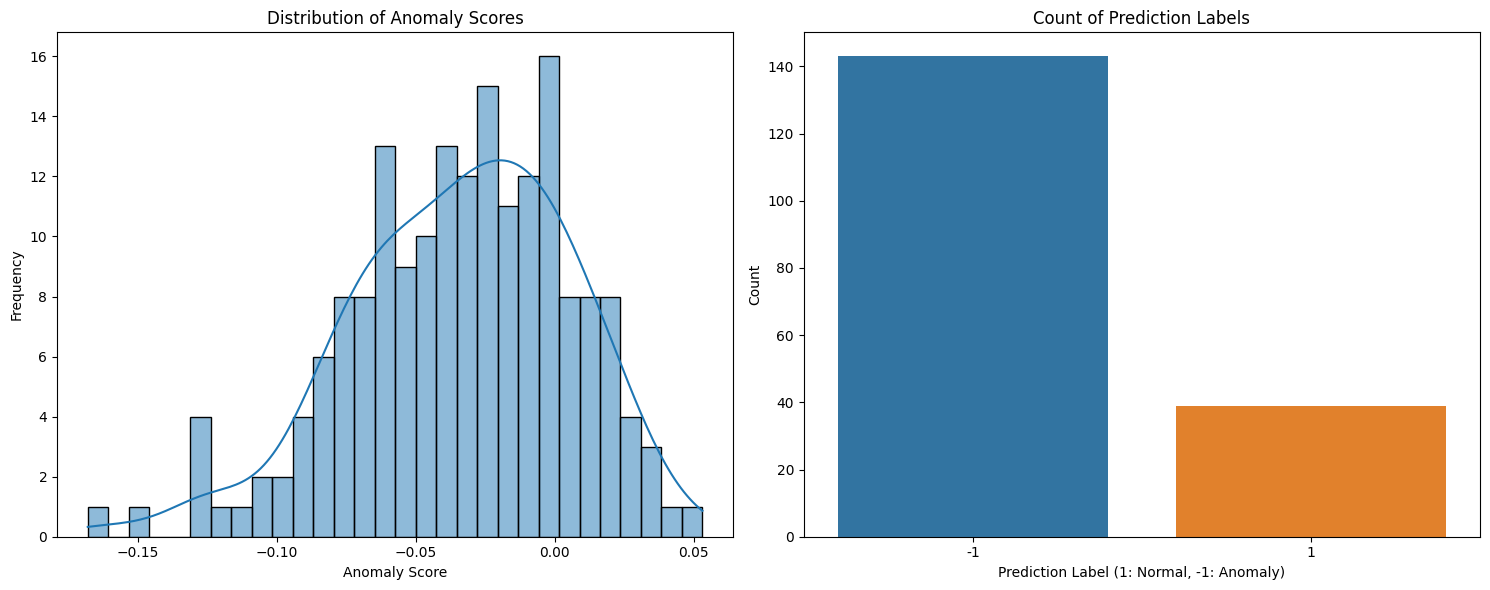

In [18]:
import seaborn as sns

# Visualize the prediction labels and anomaly scores
plt.figure(figsize=(15, 6))

# Plot the anomaly scores
plt.subplot(1, 2, 1)
sns.histplot(ops_df['Anomaly_Score'], bins=30, kde=True)
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')

# Plot the prediction labels
plt.subplot(1, 2, 2)
sns.countplot(x='Prediction_Label', data=ops_df)
plt.title('Count of Prediction Labels')
plt.xlabel('Prediction Label (1: Normal, -1: Anomaly)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()
